In [1]:
import os
import pandas as pd
import numpy as np
from dynaconf import LazySettings
from dynaconf.utils.boxing import DynaBox
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
from typing import Tuple
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [2]:
config_file = "C://workspaces//learning//fantasAi_football//config//conf.yaml"
config_mode = 'default'

In [3]:
params = LazySettings(settings_files=[config_file])
params = params[config_mode]

In [4]:
def filter_dataset(params: DynaBox, y_feature: str, dataset: pd.DataFrame) -> pd.DataFrame: 
    """Filter a dataset on the basis of the input parameters.
    
    Only a subset of data supports the learning of specific "y" features.

    Args:
        params (DynaBox): run parameters
        y_feature (str): the feature to learn
        dataset (pd.DataFrame): the dataset to filter

    Returns:
        pd.DataFrame: _description_
    """
    if y_feature in [
        params["FEATURES"]["AVG_VOTE"],
        params["FEATURES"]["FANTA_POINTS_RATIO"],
    ]:

        if params["FEATURES"]["AVG_VOTE"] in y_feature:
            dataset = dataset.loc[dataset[params["FEATURES"]["AVG_VOTE"]].notna()]
        elif params["FEATURES"]["FANTA_POINTS_RATIO"] in y_feature:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]
            # Defenders are not judged by their ability to score
            dataset = dataset.loc[
                dataset[params["FEATURES"]["POSITION_INDEX"]]
                >= params["SETTINGS"]["MIN_POS_IX_SCORE"]
            ]
            # To judge ability to score he must have played a minimum number 
            # of matches
            dataset = dataset.loc[
                dataset[params["FEATURES"]["MINUTES_PLAYED"]]
                > params["SETTINGS"]["MIN_MATCHES_SCORE"]
                * params["SETTINGS"]["MINUTES_PER_GAME"]
            ]
        elif y_feature == params["FEATURES"]["ON_FIELD_INDEX"]:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]

    print(f"Dataset size: {len(dataset)}")

    return dataset

In [5]:
def plot_scatter(cfs, df, y_feature, name="Feature plot"):
    """
    Function to plot a scatter matrix of dataset of features.
    
    Example of use:
    
    >>> plot_scatter(['DL', 'DS', 'DP', 'AD', 'DE', 'LD', 'FS'], df)
    
    :param df: pd.DataFrame
        dataframe with the data to plot
    :param cfs: list
        list of the names of the columns to plot
    :param y_feature: (default: params["FEATURES"]["FANTA_POINTS_RATIO"])
        the feature to predict
    :param name: str
        name of the file where scatter matrix will be saved
    """
    X = df[cfs]
    y = df[y_feature]
    scatter = pd.plotting.scatter_matrix(
        X,
        c=y,
        marker='o',
        s=40,
        hist_kwds={'bins':15},
        figsize=(20,20)
    )
    plt.suptitle('Scatter-matrix for each input variable')
    plt.savefig(name)

In [6]:
# Transfermarkt dataset
data_path = os.path.join(
    params["PATHS"]["ROOT_FOLDER"],
    f"{params['PATHS']['STAGES']['MATCHED_DATASET']}.pkl",
)
complete_dataset = pd.read_pickle(data_path)

Define the causal factors and the y feature

In [7]:
def setup_causal_factors(dataset, add_pred_features):

    foot_features = params["FEATURES"]["FOOT"]
    foot_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"{foot_features}_")
    ]
    side_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"side_")
    ]
    cfs = (
        [
            params["FEATURES"]["MARKET_VALUE_RATIO"],
            params["FEATURES"]["CLUB_VALUE_RATIO"],
            params["FEATURES"]["POSITION_INDEX"],
        ]
        + foot_dummy_features
        + side_dummy_features
    )

    if add_pred_features:
        # Add existing predicted features
        for y_feature in [
            params["FEATURES"]["FANTA_POINTS_RATIO"],
            params["FEATURES"]["ON_FIELD_INDEX"],
            params["FEATURES"]["AVG_VOTE"],
        ]:
            y_pred_feature = f"{y_feature}_PRED_ANS"
            if y_pred_feature in dataset.columns:
                cfs.append(y_pred_feature)        

    return cfs

In [ ]:
def train_rf(X_train, y_train, X_test, y_test, y_scaler, y_feature):
    # HINT: tried different parameters set (criterion, bootstrap off, max_depthint), with worse results.
    rf = sklearn.ensemble.RandomForestRegressor(random_state=0, bootstrap=True)
    rf.fit(X_train, y_train)
    print(f"RF: score on training set: {rf.score(X_train, y_train):.3f}")
    print(f"RF: score of on test set: {rf.score(X_test, y_test):.3f}")
    # yhat_rf=rf.predict(X_test)

    plot_test_regression(rf, y_scaler, X_test, y_test, f"RF - {y_feature}")

    return rf

def plot_nn_loss(history, y_feature):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    _, ax1 = plt.subplots()
    ax1.plot(loss,label = 'Loss')
    ax1.plot(val_loss, label = 'Validation Loss')
    ax1.legend()
    ax1.set_title(f"Neural Net Loss - {y_feature}")

def train_nn(cfs, X_train, y_train, X_test, y_test, y_scaler, y_feature):
    model = Sequential()
    model.add(
        Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu")
    )
    # model.add(Dropout(0.2))
    model.add(
        Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu")
    )
    # model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))

    es = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=1,
        min_delta=0.0001,
        patience=20,
        restore_best_weights=True,
    )

    model.compile(loss=MeanSquaredLogarithmicError(), optimizer="adam")

    # HINT: tried with different epochs and batch_size, worse results
    X_train = np.asarray(X_train).astype("float32")
    y_train = np.asarray(y_train).astype("float32")
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=100,
        validation_split=0.2,
        callbacks=[es],
        verbose=0,
    )

    plot_test_regression(model, y_scaler, X_test, y_test, f"Neural Net - {y_feature}")
    plot_nn_loss(history, y_feature)

    return model
    
def plot_test_regression(model, y_scaler, X_test, y_test, title):
    predict = pd.Series(
        data=y_scaler.inverse_transform(
            model.predict(X_test).reshape(-1, 1)
        ).flatten()
    )
    actuals = pd.Series(data=y_scaler.inverse_transform(y_test).flatten())
    frame = {"PREDICT": predict, "ACTUALS": actuals}
    results = pd.DataFrame(frame)
    results.plot.scatter(x="PREDICT", y="ACTUALS", c="DarkBlue", title=title)


def predict(nn_model, rf_model, y_scaler, dataset, X_complete, y_feature):
    X = np.asarray(X_complete).astype("float32")
    
    y_pred_nn = y_scaler.inverse_transform(nn_model.predict(X)).flatten()
    y_pred_rf = y_scaler.inverse_transform(rf_model.predict(X)).flatten()

    results = dataset.copy()
    results[f"{y_feature}_PRED_NN"] = y_pred_nn
    results[f"{y_feature}_PRED_RF"] = y_pred_rf
    results[f"{y_feature}_PRED_ANS"] = (
        results[f"{y_feature}_PRED_NN"] + results[f"{y_feature}_PRED_RF"]
    ) / 2
    results[f"{y_feature}_APE_NN"] = (
        abs(results[f"{y_feature}_PRED_NN"] - results[y_feature])
        / results[y_feature]
    )
    results[f"{y_feature}_APE_RF"] = (
        abs(results[f"{y_feature}_PRED_RF"] - results[y_feature])
        / results[y_feature]
    )
    results[f"{y_feature}_APE_ANS"] = (
        abs(results[f"{y_feature}_PRED_ANS"] - results[y_feature])
        / results[y_feature]
    )
    for c in [
        f"{y_feature}_APE_NN",
        f"{y_feature}_APE_RF",
        f"{y_feature}_APE_ANS",
    ]:
        results.loc[results[c] == np.inf, c] = 1

    return results


def train_predict(
    params: DynaBox,
    complete_dataset: pd.DataFrame,
    y_feature: str,
    add_pred_features: bool,
):
    """Formulates and train models, and make predictions, for a feature.

    Args:
        params (DynaBox): run parameters
        complete_dataset (pd.DataFrame): the complete dataset available. This
            method will filter the rows that are valid for the specific
            feature to predict
        y_feature (str): the name feature to predict
        add_pred_features (bool): if True, it adds to the input features
            one or more features that has been predicted using other models.

    Returns:
        _type_: _description_
    """

    print(f"Training and predicting {y_feature}...")

    dataset = filter_dataset(params, y_feature, complete_dataset)

    cfs = setup_causal_factors(dataset, add_pred_features)

    if params["SETTINGS"]["PLOT_SCATTER"]:
        plot_scatter(cfs, dataset[:1000], y_feature)

    val_mask = dataset["season"] == params["SETTINGS"]["VALIDATION_YEAR"]
    dataset["VALIDATION"] = np.where(val_mask, 1, 0)
    train_dataset = dataset.loc[dataset["VALIDATION"] == 0]

    X_complete = dataset[cfs].to_numpy()
    y_complete = dataset[y_feature].to_numpy()

    X = train_dataset[cfs].to_numpy()
    y = train_dataset[y_feature].to_numpy()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, random_state=0
    )

    x_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    x_scaler = x_scaler.fit(X_complete)

    y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    y_scaler = y_scaler.fit(y_complete.reshape(-1, 1))

    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)

    y_train = y_scaler.transform(y_train.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    rf_model = train_rf(X_train, y_train, X_test, y_test, y_scaler, y_feature)
    nn_model = train_nn(cfs, X_train, y_train, X_test, y_test, y_scaler, y_feature)

    dataset = predict(nn_model, rf_model, y_ dataset, X_complete, y_feature)

    print(f"... {y_feature} train and predict done.")

    return dataset


Training and predicting fanta_points_ratio...
Dataset size: 14752


C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_66596\947110078.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RF: score on training set: 0.910
RF: score of on test set: 0.406
Restoring model weights from the end of the best epoch: 27.
Epoch 47: early stopping


TypeError: predict() missing 1 required positional argument: 'y_feature'

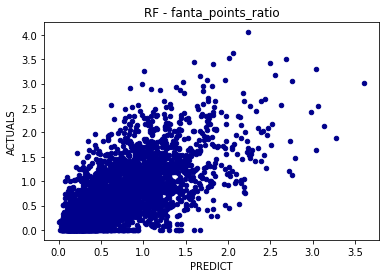

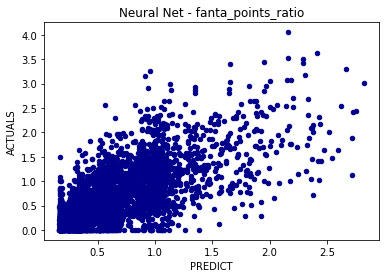

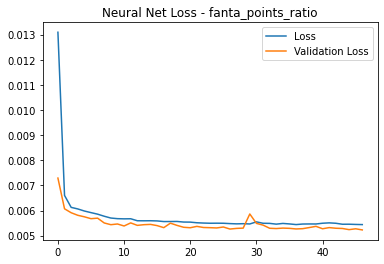

In [52]:
bonus = params["FEATURES"]["FANTA_POINTS_RATIO"]
on_field = params["FEATURES"]["ON_FIELD_INDEX"]
vote = params["FEATURES"]["AVG_VOTE"]

dataset_bonus = train_predict(params, complete_dataset, bonus, False)

dataset_vote = train_predict(params, complete_dataset, vote, True)

dataset_on_field = train_predict(params, complete_dataset, on_field, True)

# results = results[["APE", "APE_RF", "APE_ANS"]].fillna(0)
#val_dataset[["APE", "APE_RF", "APE_ANS"]].mean()

In [10]:
dataset_bonus[[f"{bonus}_APE_NN", f"{bonus}_APE_RF", f"{bonus}_APE_ANS"]].mean()

fanta_points_ratio_APE_NN     4.800300
fanta_points_ratio_APE_RF     1.513414
fanta_points_ratio_APE_ANS    3.047054
dtype: float64

In [11]:
dataset_on_field[[f"{on_field}_APE_NN", f"{on_field}_APE_RF", f"{on_field}_APE_ANS"]].mean()

on_field_index_APE_NN     4.466679
on_field_index_APE_RF     2.213121
on_field_index_APE_ANS    3.309610
dtype: float64

In [12]:
dataset_vote[[f"{vote}_APE_NN", f"{vote}_APE_RF", f"{vote}_APE_ANS"]].mean()

vote_average_APE_NN     0.772956
vote_average_APE_RF     0.887380
vote_average_APE_ANS    0.830168
dtype: float64

In [49]:
def print_top_players(df, y_feature, competition_id="IT1", head=10):
    df_c = df.loc[df["competition_id"] == competition_id]
    df_c = df_c.sort_values(by=[f"{y_feature}_PRED_NN"], ascending=False).head(
        head
    )
    df_c = df_c[
        [
            "pretty_name",
            "club_pretty_name",
            "goals",
            "assists",
            y_feature,
            "played_matches",
            f"{y_feature}_PRED_NN",
            f"{y_feature}_PRED_RF",
            f"{y_feature}_PRED_ANS",
        ]
    ]

    return df_c


In [50]:
print_top_players(dataset_vote, vote)

,pretty_name,club_pretty_name,goals,assists,vote_average,played_matches,vote_average_PRED_NN,vote_average_PRED_RF,vote_average_PRED_ANS
45261,Paulo Dybala,Juventus Turin,5,2,6.8,27,6.349908,0.697787,3.523848
45543,Cristiano Ronaldo,Juventus Turin,21,8,8.79,31,6.079651,0.718739,3.399195
45387,Gonzalo Higuain,Juventus Turin,16,3,7.34,34,5.983155,0.718739,3.350947
45383,Gonzalo Higuain,Juventus Turin,24,3,8.26,38,5.655090,0.718739,3.186915
40973,Mauro Icardi,Inter Mailand,11,4,6.98,29,5.599410,0.718739,3.159075
45259,Paulo Dybala,Juventus Turin,22,5,8.36,33,5.400838,0.697787,3.049313
45181,Paul Pogba,Juventus Turin,8,10,7.13,35,5.002998,0.705229,2.854114
211,Sergej Milinković Savić,Lazio Rom,5,3,6.34,31,4.896837,0.718739,2.807788
45255,Paulo Dybala,Juventus Turin,11,7,7.91,29,4.574278,0.697787,2.636033
45266,Paulo Dybala,Juventus Turin,4,3,6.45,19,4.498855,0.697787,2.598321
